In [124]:
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import hopsy
import x3cflux
x3cflux.logging.level = 0
import pandas as pd
from scipy import stats



# Multi-Level Delayed Acceptance

## Setup

First, load the data from FluxML. The corresponding labeling model has 60 DOF.

In [2]:
simulator_hf = x3cflux.create_simulator_from_fml("spiralus.fml","ms_INST")
simulator_hf.parameter_space.num_free_parameters

4

Preconfigured relative/absolute tolerance for the forward simulation and the gradient are $10^{-6}$/$10^{-9}$.

In [3]:
simulator_hf.builder.solver.relative_tolerance, simulator_hf.builder.derivative_solver.relative_tolerance

(1e-06, 1e-06)

Now, create a mid fidelity simulator which only uses $10^{-3}$/$10^{-6}$ for simulation and gradient.

In [4]:
simulator_mf = x3cflux.create_simulator_from_fml("spiralus.fml", "ms_INST")
simulator_mf.builder.solver.relative_tolerance = 1e-3
simulator_mf.builder.solver.absolute_tolerance = 1e-4
simulator_mf.builder.derivative_solver.relative_tolerance = 1e-3
simulator_mf.builder.derivative_solver.absolute_tolerance = 1e-4

same for a low fidelity simulator 

In [16]:
simulator_lf = x3cflux.create_simulator_from_fml("spiralus.fml", "ms_INST")
simulator_lf.builder.solver.relative_tolerance = 1e-1
simulator_lf.builder.solver.absolute_tolerance = 1e-2
simulator_lf.builder.derivative_solver.relative_tolerance = 1e-1
simulator_lf.builder.derivative_solver.absolute_tolerance = 1e-2

Get an inital point in the polytope and check how the simulation speeds differ.

In [11]:
ineq_sys = simulator_hf.parameter_space.inequality_system
initial_point = x3cflux.get_parameters(simulator_hf.parameter_space, simulator_hf.configurations[0].parameter_entries) #starting_point

In [12]:
%timeit simulator_hf.compute_loss(initial_point)

1.83 ms ± 162 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [13]:
%timeit simulator_mf.compute_loss(initial_point)

603 μs ± 26.1 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [17]:
%timeit simulator_lf.compute_loss(initial_point)

249 μs ± 5.48 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## Define the Multi-Level Delayed Acceptance proposal

In [18]:
class DelayedAcceptanceProposal:
    def __init__(self, problem: hopsy.Problem, problem_lf: hopsy.Problem, proposal_object,length: int = 10):
        self.problem = problem
        self.state = self.proposal = problem.starting_point
        self.state_log_density = problem.model.log_density(self.state)
        self.proposal_log_density = self.state_log_density
    
        init_chain_lf = hopsy.MarkovChain(problem_lf,starting_point=self.state)
        init_chain_lf.proposal=proposal_object
        self.chain_lf = init_chain_lf
        #print(self.chain_lf)
        self.length: int = length
        self.state_log_density_lf = self.chain_lf.state_log_density

    def propose(self, rng: hopsy.RandomNumberGenerator) -> np.ndarray:
        self.chain_lf.state = self.state
        for i in range(self.length):
            self.chain_lf.draw(rng)
        self.proposal = self.chain_lf.state
        self.proposal_log_density = self.problem.model.log_density(self.proposal)
        return self.proposal
    
    def accept_proposal(self) -> np.ndarray:
        self.state = self.proposal
        self.state_log_density = self.proposal_log_density
        self.state_log_density_lf = self.chain_lf.state_log_density
        return self.state

    def log_acceptance_probability(self) -> float:
        return self.proposal_log_density - self.state_log_density + \
            self.state_log_density_lf - self.chain_lf.state_log_density

In [61]:
def configure_mlda(models : hopsy.Problem, chain_lengths: int, mh_proposal: hopsy.Proposal):
    
    levels = len(chain_lengths)
    
    da_proposals = [mh_proposal]     
    
    for l in range(1,levels):
        da_proposals.append(DelayedAcceptanceProposal(models[l],models[l-1],proposal_object=da_proposals[l-1],length = chain_lengths[l-1]))
    return da_proposals[-1]

## Sample models

In [120]:
n_samples = 2000
n_burnin = 100


In [80]:
problem_0 = hopsy.Problem(ineq_sys.matrix, ineq_sys.bound, x3cflux.HopsyModel(simulator_lf))
problem_0.starting_point = initial_point

problem_1 = hopsy.Problem(ineq_sys.matrix, ineq_sys.bound, x3cflux.HopsyModel(simulator_mf))
problem_1.starting_point = initial_point

problem_2 = hopsy.Problem(ineq_sys.matrix, ineq_sys.bound, x3cflux.HopsyModel(simulator_hf)) 
problem_2.starting_point = initial_point


""" set-up mlda proposals and markov-chains """

mlda_chain_lengths = [2,2]

mlda_proposals = [configure_mlda(models=[problem_0,problem_1,problem_2],chain_lengths=mlda_chain_lengths,mh_proposal=hopsy.CSmMALAProposal(problem_0)) for i in range(4)]
mlda_rngs = [hopsy.RandomNumberGenerator(seed = 42 + 42*i) for i in range(4)]

print(mlda_proposals)

mlda_chains = [hopsy.MarkovChain(problem=problem_2,starting_point=initial_point) for i in range(4)]

for i in range(4):
    mlda_chains[i].proposal = mlda_proposals[i] 
    

[<__main__.DelayedAcceptanceProposal object at 0x7fdc0c3030b0>, <__main__.DelayedAcceptanceProposal object at 0x7fdc0c302f00>, <__main__.DelayedAcceptanceProposal object at 0x7fdc0c303020>, <__main__.DelayedAcceptanceProposal object at 0x7fdc0c302f90>]


In [81]:
"""sample MLDA-MCMC""" 

mlda_meta, mlda_samples = hopsy.sample(mlda_chains, mlda_rngs, n_samples, record_meta=["acceptance_rate", "state_log_density"], progress_bar=True)

np.save("mlda_samples.npy",mlda_samples)
np.save("mlda_meta.npy",mlda_meta)


chain 0:   0%|          | 0/2000 [00:00<?, ?it/s]

chain 3: 100%|██████████| 2000/2000 [00:38<00:00, 51.41it/s]


In [93]:

mlda_meta = np.load("mlda_meta.npy", allow_pickle=True)
mlda_samples = np.load("mlda_samples.npy")

print("r_hats", hopsy.rhat(mlda_samples[:,n_burnin:,:]))
print("mlda_ess",((hopsy.ess(mlda_samples[:,n_burnin:,:]))))
print("mlda_acceptance_rate",mlda_meta.item().get("acceptance_rate").mean(axis=1))


mlda_durations = np.array([41,40,37,38,])
print("mlda durations in min ", mlda_durations)

print("MLDA-ESS per Second: ", np.median(hopsy.ess(mlda_samples[:,n_burnin:,:,])/(mlda_durations)))

r_hats [[1.01044922 1.01432767 1.03831211 1.01001127]]
mlda_ess [[415.57759606 318.21338868  50.12879987 377.45695974]]
mlda_acceptance_rate [0.76   0.7605 0.739  0.752 ]
mlda durations in min  [41 40 37 38]
MLDA-ESS per Second:  8.94420630250141


In [87]:
test_chains = [hopsy.MarkovChain(problem_2,proposal=hopsy.CSmMALAProposal, starting_point = initial_point) for i in range(4)]
test_rngs = [hopsy.RandomNumberGenerator(seed = (i+5)*42) for i in range(4)]

for mc in test_chains:
    mc.proposal.stepsize = 0.5
    mc.proposal.fisher_weight = 0.9



In [88]:
test_meta, test_samples = hopsy.sample(test_chains,test_rngs,n_samples=n_samples,record_meta=["acceptance_rate", "state_log_density"],progress_bar=True)

np.save("test_samples.npy",test_samples)
np.save("test_meta.npy",test_meta)


chain 3: 100%|██████████| 2000/2000 [00:54<00:00, 36.48it/s]


In [92]:
test_samples = np.load("test_samples.npy")
test_meta = np.load("test_meta.npy",allow_pickle = True)


print("r_hats", hopsy.rhat(test_samples[:,n_burnin:,:]))
print("test_ess",(hopsy.ess(test_samples[:,n_burnin:,:])))
print("test_acceptance_rate",test_meta.item().get("acceptance_rate").mean(axis=1))

test_durations =np.array([50,55,55,54])

print("test durations in sec ", test_durations)

print("test-ESS per Second: ", np.median(hopsy.ess(test_samples[:,n_burnin:,:,])/(test_durations)))

r_hats [[1.01232326 1.02319649 1.04716707 1.02146109]]
test_ess [[372.75046011 298.20746744 117.70174182 321.51759304]]
test_acceptance_rate [0.459  0.4785 0.4615 0.4745]
test durations in sec  [50 55 55 54]
test-ESS per Second:  5.687991727157107


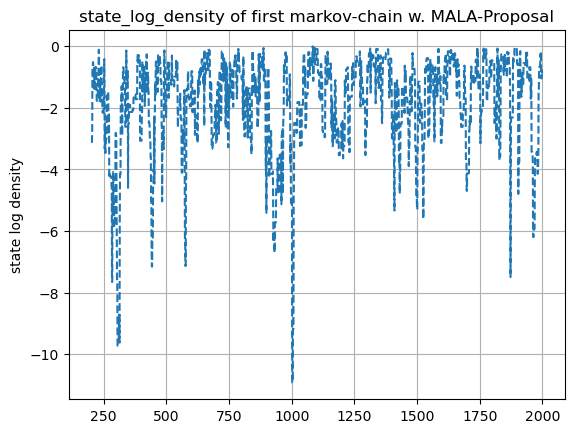

In [117]:
#plt.plot(range(0, n_samples), meta["state_log_density"][:, n_burnin:].T, ls="-")
plt.figure()
plt.title("state_log_density of first markov-chain w. MALA-Proposal")
plt.xlabel("state-trajectory")
plt.ylabel("state log density")
plt.xlabel("")
plt.plot(range(n_burnin,n_samples), test_meta.item().get("state_log_density")[0,n_burnin:].T, ls = "--")
plt.grid()

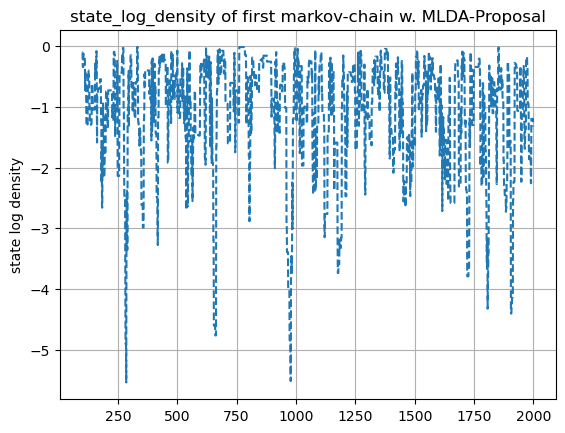

In [122]:
#plt.plot(range(0, n_samples), meta["state_log_density"][:, n_burnin:].T, ls="-")
plt.figure()
plt.title("state_log_density of first markov-chain w. MLDA-Proposal")
plt.xlabel("state-trajectory")
plt.ylabel("state log density")
plt.xlabel("")
plt.plot(range(n_burnin,n_samples), mlda_meta.item().get("state_log_density")[0,n_burnin:].T, ls = "--")
plt.grid()

Text(0.5, 1.0, 'mala ')

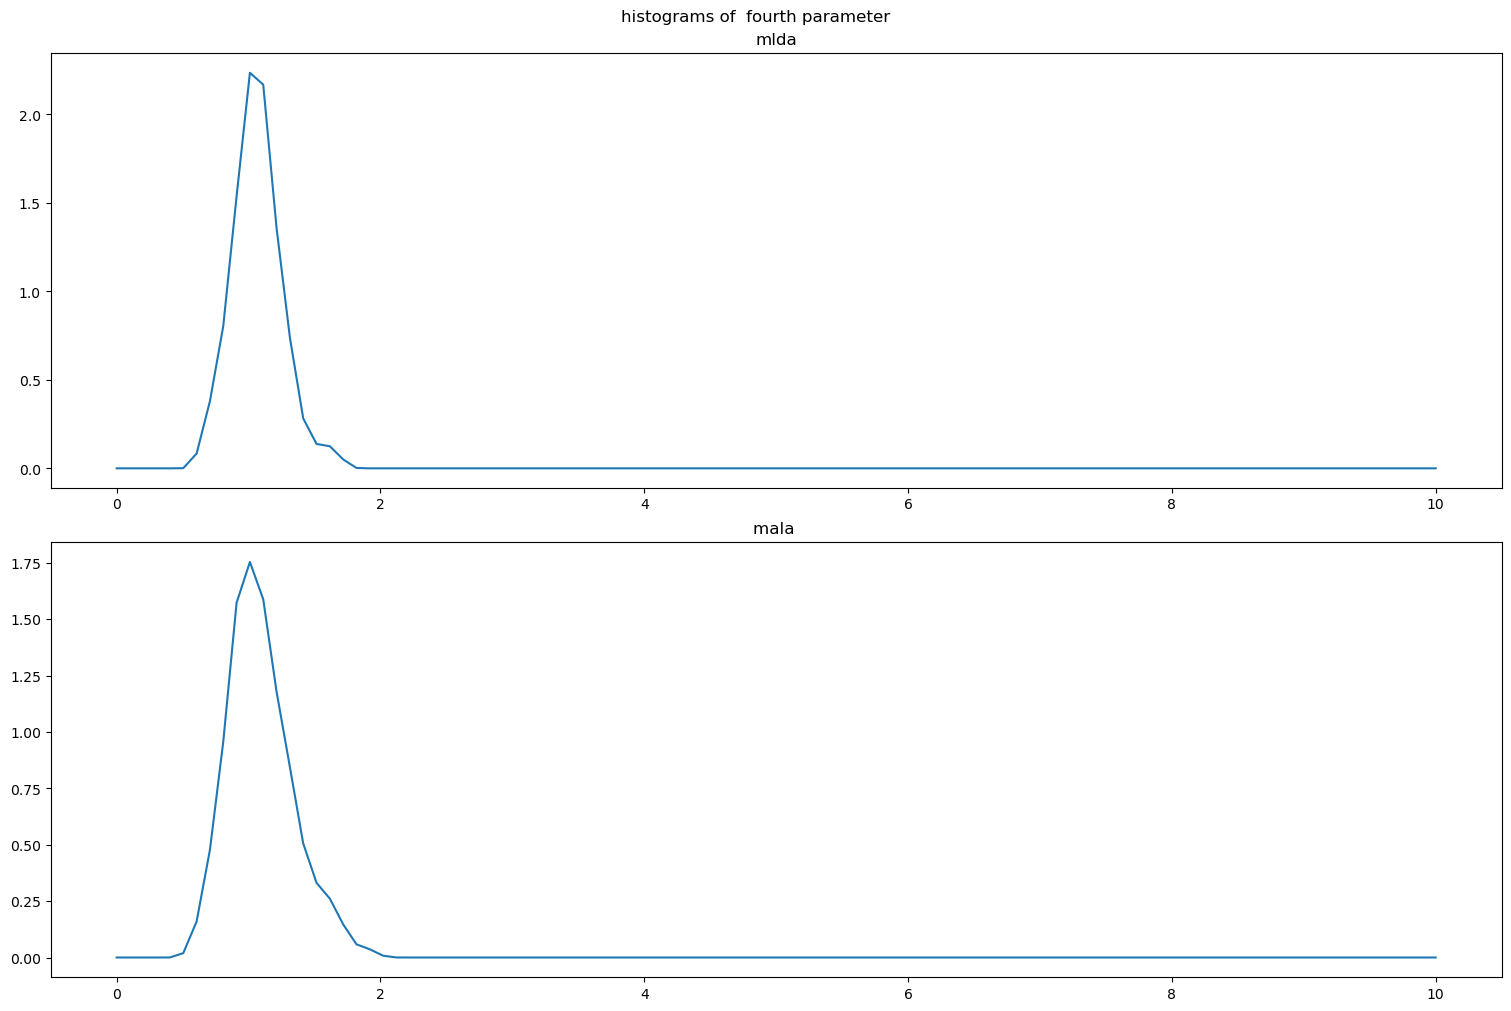

In [138]:
mlda_run = mlda_samples[0,n_burnin:,:]
test_run  = test_samples[0,n_burnin:,:]

mlda_density = stats.gaussian_kde(mlda_run[:,3],bw_method = "silverman")
test_density = stats.gaussian_kde(test_run[:,3], bw_method = "silverman")

x_vals = np.linspace(0,10,100)

fig , (ax1,ax2) = plt.subplots(2,1, figsize = (15,10), layout="constrained")
fig.suptitle("histograms of  fourth parameter")
ax1.set_title("mlda")
ax1.plot(x_vals, mlda_density(x_vals))
ax2.plot(x_vals, test_density(x_vals))
ax2.set_title("mala ")


Text(0.5, 1.0, 'mala ')

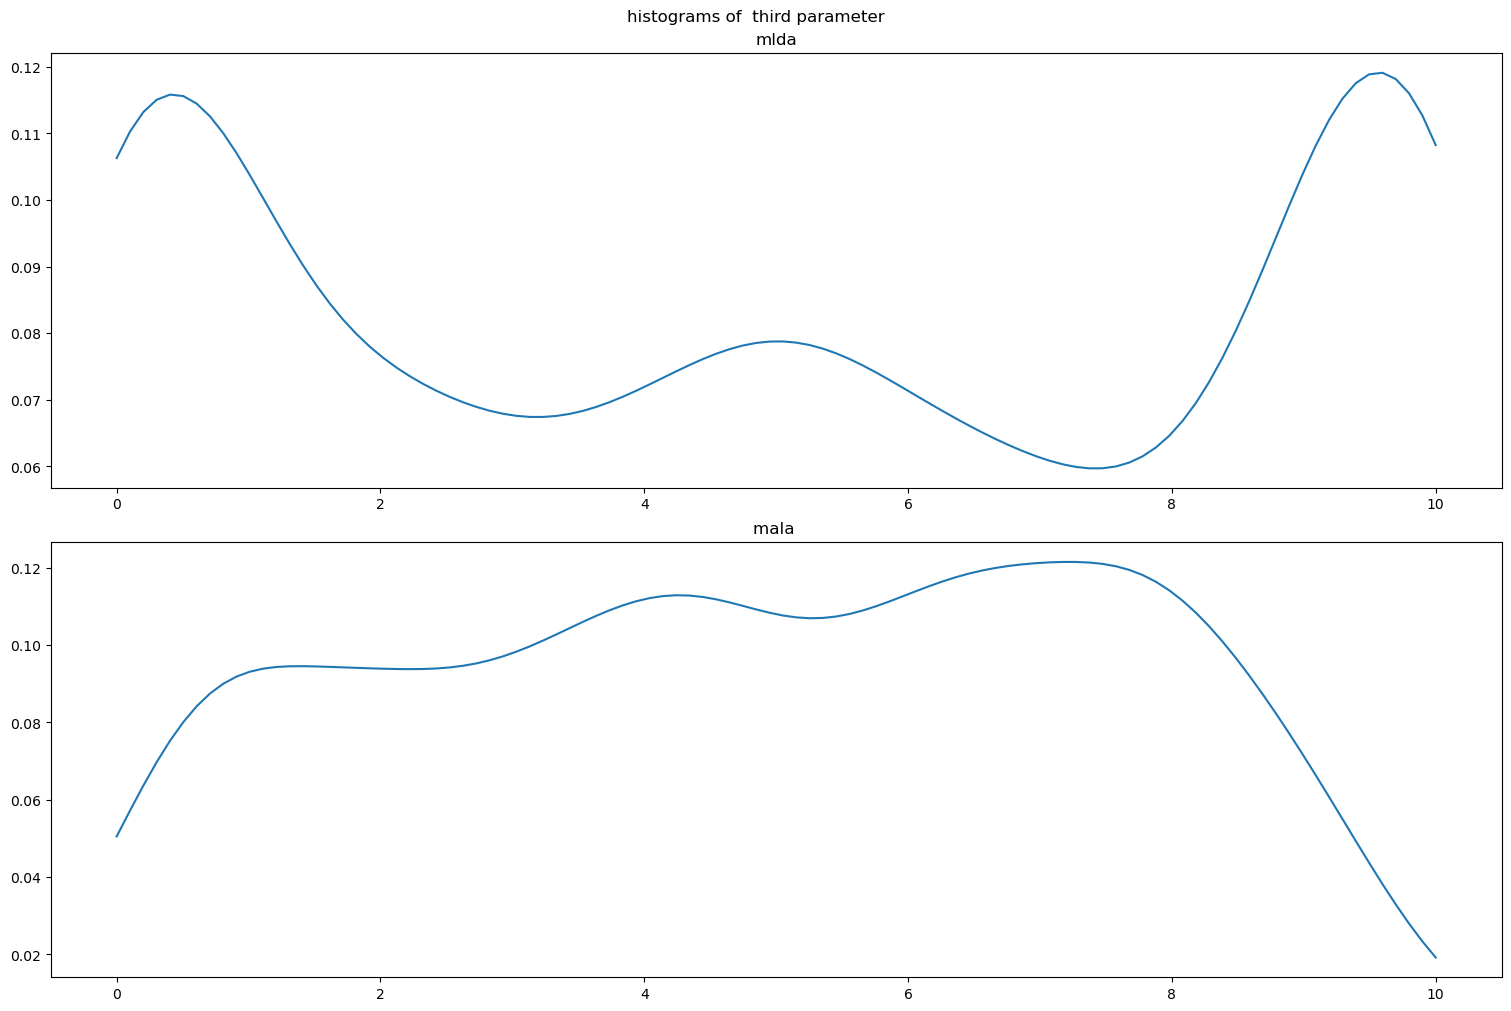

In [137]:
mlda_density = stats.gaussian_kde(mlda_run[:,2],bw_method = "silverman")
test_density = stats.gaussian_kde(test_run[:,2], bw_method = "silverman")

x_vals = np.linspace(0,10,100)

fig , (ax1,ax2) = plt.subplots(2,1, figsize = (15,10), layout="constrained")
fig.suptitle("histograms of  third parameter")
ax1.set_title("mlda")
ax1.plot(x_vals, mlda_density(x_vals))
ax2.plot(x_vals, test_density(x_vals))
ax2.set_title("mala ")
